In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from os import path
import sys
sys.path.append(path.join(".."))

import saly
import saly.backend as S
import pandas as pd
import numpy as np
import scanpy as sc

%load_ext autoreload
%autoreload 2

EPOCHS = 25
SPECIES = 'Mouse'
DATA_PATH = '/home/mlongar/Data/SingleCellGeneExpression/'
DATASET_HRVATIN_PATH = DATA_PATH + 'hrvatin_2018.h5ad' 
DATASET_CHEN_PATH = DATA_PATH + 'chen_2017.h5ad'
DATASET_BIG_PATH = DATA_PATH + 'cao_2019.h5ad'
MARKER_PATH = DATA_PATH + 'panglao_gene_markers.tab.gz'

Using TensorFlow backend.


In [2]:
hrvatin_data = saly.load_h5ad(DATASET_HRVATIN_PATH)
print("HRVATIN DATA\n", hrvatin_data.shape)

HRVATIN DATA
 (48266, 25186)


In [3]:
chen_data = saly.load_h5ad(DATASET_CHEN_PATH)
print("CHEN DATA\n", chen_data.shape)

CHEN DATA
 (14437, 23284)


In [4]:
big_data = saly.load_h5ad(DATASET_BIG_PATH)
print("BIG DATA\n", big_data.shape)

BIG DATA
 (2058652, 26158)


In [5]:
chen_data = saly.drop_rows(chen_data, ['tanycyte', 'unknown', 'ependymal cell', 'epithelial cell'])

Dropped 4750 cell(s). New shape: (9687, 23284)


In [6]:
markers_db = saly.load_markers(MARKER_PATH, SPECIES)
markers = saly.get_mutual_markers([hrvatin_data, chen_data, big_data], markers_db)
print('Mutual markers:', len(markers))

Mutual markers: 6815


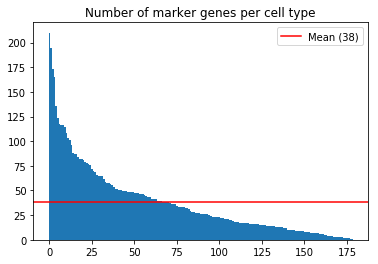

In [7]:
saly.plot_marker_genes(markers)

In [8]:
marker_aliases = {'Neuron' : 'Neurons',
                'Oligodendrocyte' : 'Oligodendrocytes',
                'Muscle cell' : 'Smooth muscle cells',
                'Endothelial cell' : 'Endothelial cells',
                'Astrocyte' : 'Astrocytes',
                'Macrophage' : 'Macrophages',
                'OPC' : 'Oligodendrocyte progenitor cells',
                'Pericyte' : 'Pericytes'}

saly.check_labels([hrvatin_data, chen_data], markers, marker_aliases)

In [9]:
hrvatin_data = saly.drop_unused_genes(hrvatin_data, markers)
chen_data = saly.drop_unused_genes(chen_data, markers)
big_data = saly.drop_unused_genes(big_data, markers)

saly.check_shape([hrvatin_data, chen_data, big_data])

Dropped 21450 gene(s). New shape: (48266, 3736)
Dropped 19548 gene(s). New shape: (9687, 3736)
Dropped 22422 gene(s). New shape: (2058652, 3736)


In [10]:
def drop_unused_rows(data, rows_to_keep: list):
    n_dropped = data.shape[0] - len(rows_to_keep)
    data = data[rows_to_keep, :]

    print("Dropped {0} cell(s).".format(n_dropped), "New shape:", data.shape)

    return data

In [11]:
cpm_data = big_data.copy()
sc.pp.normalize_total(cpm_data, target_sum=1e6)
metrics = sc.pp.calculate_qc_metrics(cpm_data)
average_metrics = metrics[0].sum() / metrics[0].shape[0]

In [12]:
selected_cells = metrics[0].loc[metrics[0]['n_genes_by_counts'] >= average_metrics['n_genes_by_counts']]
big_data = drop_unused_rows(big_data, selected_cells.index.values.tolist())

Dropped 1216001 cell(s). New shape: (842651, 3736)


In [13]:
big_data = saly.mark_as_unlabelled(big_data.copy())

In [14]:
train_data, _, _ = saly.preprocess_data(big_data, splits=10,
                                       train=1, test=0, validation=0)

In [15]:
chen_data = S.normalize_data(chen_data.copy())
hrvatin_data = S.normalize_data(hrvatin_data.copy())

In [18]:
model, marker_model, encoder_model = saly.build_model(train_data, markers, supervised=False);

In [ ]:
history = saly.train_model(model, train_data, markers, marker_aliases,
                           1, validation_data=chen_data, verbose=1)

Train on 842651 samples, validate on 9687 samples
Epoch 1/1
666624/842651 [======================>.......] - ETA: 11s - loss: 2464.1232 - cell_activations_loss: 0.0000e+00 - output_loss: 2.4641 - cell_activations_marker_prediction_metric: 0.0000e+00

In [ ]:
saly.plot_model_history(history, supervised=False, labelled_training=False)

In [23]:
chen_cell_activations = marker_model.predict(chen_data.X)
saly.get_results(chen_data.obs['labels'], chen_cell_activations, markers, marker_aliases)

Correct predictions: 2477 out of 9687 (25.57%)
	Neuron: 99.57% (2305/2315) | Markers: 195
	Oligodendrocyte: 0.0% (0/3541) | Markers: 82
	OPC: 0.22% (4/1792) | Markers: 26
	Astrocyte: 0.0% (0/1148) | Markers: 59
	Microglia: 6.22% (45/724) | Markers: 78
	Macrophage: 73.65% (123/167) | Markers: 116


0.2557035201816868

In [24]:
hrvatin_cell_activations = marker_model.predict(hrvatin_data.X)
saly.get_results(hrvatin_data.obs['labels'], hrvatin_cell_activations, markers, marker_aliases)

Correct predictions: 19582 out of 48266 (40.57%)
	Neuron: 99.99% (15221/15223) | Markers: 195
	Oligodendrocyte: 1.77% (153/8630) | Markers: 82
	Muscle cell: 0.0% (0/621) | Markers: 77
	Astrocyte: 0.44% (31/7039) | Markers: 59
	Endothelial cell: 99.97% (3449/3450) | Markers: 173
	Macrophage: 94.41% (507/537) | Markers: 116
	Microglia: 1.85% (188/10158) | Markers: 78
	OPC: 0.11% (2/1826) | Markers: 26
	Pericyte: 3.96% (31/782) | Markers: 62


0.40571002361911074